In [1]:
import os
print(os.listdir("../input"))

['zindi-calls', 'zindi-calls-test']


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd

In [3]:
train=pd.read_csv("../input/zindi-calls/train.csv")
test=pd.read_csv("../input/zindi-calls-test/Sample_Submission (2).csv")
weather = pd.read_excel('../input/zindi-calls/WeatherNairobi2016.xls',skiprows=6)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (12,13,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train.head().T

,0,1,2,3,4
calldate,2016-01-01 07:26:47,2016-01-01 07:32:30,2016-01-01 07:44:31,2016-01-01 07:46:13,2016-01-01 07:47:22
cc_status,Closed,Closed,Closed,Closed,Closed
maincat,non-interventional,non-interventional,non-interventional,others,non-interventional
subcat1,Blank call,Blank call,Blank call,Unrelated to remit of Childline 116,Blank call
casepriority,Non Critical,Non Critical,Non Critical,Non Critical,Non Critical
referal,NaN,NaN,NaN,NaN,NaN
caller_gender,NaN,NaN,NaN,Male,NaN
caller_age,NaN,NaN,NaN,Adult,NaN
caller_county,NaN,NaN,NaN,Nyeri,NaN
child_age,NaN,NaN,NaN,NaN,NaN


In [5]:
weather.head(10)

,Local time in Nairobi (airport),T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,31.12.2016 21:00,20.2,NaN,NaN,NaN,68.0,Wind blowing from the east-northeast,8.0,NaN,NaN,70 – 80%.,,NaN,NaN,NaN,27.5,Stratocumulus other than Stratocumulus cumulog...,60%.,600-1000,Altocumulus translucidus at a single level.,"No Cirrus, Cirrocumulus or Cirrostratus.",30.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
1,31.12.2016 15:00,26.0,NaN,NaN,NaN,40.0,Wind blowing from the north-east,9.0,NaN,NaN,40%.,,NaN,NaN,NaN,NaN,"Cumulonimbus capillatus (often with an anvil),...",40%.,600-1000,"No Altocumulus, Altostratus or Nimbostratus.","No Cirrus, Cirrocumulus or Cirrostratus.",30.0,11.2,NaN,NaN,NaN,NaN,NaN,NaN
2,31.12.2016 09:00,18.8,NaN,NaN,NaN,85.0,Wind blowing from the north-northeast,5.0,NaN,NaN,60%.,,NaN,NaN,NaN,NaN,Stratocumulus other than Stratocumulus cumulog...,40%.,300-600,Altocumulus translucidus at a single level.,"No Cirrus, Cirrocumulus or Cirrostratus.",25.0,16.2,Trace of precipitation,24.0,NaN,NaN,NaN,NaN
3,30.12.2016 21:00,19.5,NaN,NaN,NaN,79.0,Wind blowing from the east-northeast,4.0,NaN,NaN,40%.,,NaN,NaN,NaN,26.9,Stratocumulus cumulogenitus.,40%.,600-1000,Altocumulus translucidus at a single level.,"No Cirrus, Cirrocumulus or Cirrostratus.",20.0,15.8,NaN,NaN,NaN,NaN,NaN,NaN
4,30.12.2016 15:00,24.5,NaN,NaN,NaN,56.0,Wind blowing from the east-northeast,7.0,NaN,NaN,70 – 80%.,,NaN,NaN,NaN,NaN,"Cumulonimbus capillatus (often with an anvil),...",40%.,600-1000,Altocumulus translucidus at a single level.,Cirrus spissatus cumulonimbogenitus.,30.0,15.1,NaN,NaN,NaN,NaN,NaN,NaN
5,30.12.2016 09:00,18.6,NaN,NaN,NaN,90.0,Wind blowing from the east-northeast,1.0,NaN,NaN,"90 or more, but not 100%",,NaN,NaN,16.7,NaN,Cumulus and Stratocumulus other than Stratocum...,60%.,300-600,Altocumulus translucidus at a single level.,NaN,30.0,16.9,1,24.0,NaN,NaN,NaN,NaN
6,30.12.2016 03:00,17.4,NaN,NaN,NaN,79.0,Wind blowing from the north-east,5.0,NaN,NaN,"10% or less, but not 0",,NaN,NaN,NaN,NaN,Stratocumulus other than Stratocumulus cumulog...,"10% or less, but not 0",300-600,"No Altocumulus, Altostratus or Nimbostratus.","No Cirrus, Cirrocumulus or Cirrostratus.",30.0,13.6,NaN,NaN,NaN,NaN,NaN,NaN
7,29.12.2016 21:00,21.8,NaN,NaN,NaN,65.0,Wind blowing from the east-northeast,5.0,NaN,NaN,"90 or more, but not 100%",,NaN,NaN,NaN,27.4,Stratocumulus other than Stratocumulus cumulog...,"90 or more, but not 100%",600-1000,NaN,NaN,30.0,14.8,NaN,NaN,NaN,NaN,NaN,NaN
8,29.12.2016 15:00,27.2,NaN,NaN,NaN,44.0,Wind blowing from the east,5.0,NaN,NaN,70 – 80%.,,NaN,NaN,NaN,NaN,"Cumulonimbus capillatus (often with an anvil),...","10% or less, but not 0",600-1000,Altostratus opacus or Nimbostratus.,NaN,30.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
9,29.12.2016 09:00,19.8,NaN,NaN,NaN,76.0,Wind blowing from the north,3.0,NaN,NaN,"90 or more, but not 100%",,NaN,NaN,15.4,NaN,Stratocumulus other than Stratocumulus cumulog...,50%.,300-600,Altocumulus translucidus at a single level.,NaN,30.0,15.4,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train.shape

(135988, 19)

In [8]:
train['calldate']=pd.to_datetime(train['calldate'])

In [9]:
def transform(x):
    if len(x)!=2:
        a='0'+x
    else:
        a=x
    return a

In [10]:
train['Year']=train['calldate'].dt.year.astype('str')
train['Month']=train['calldate'].dt.month.astype('str').apply(transform)
train['Day']=train['calldate'].dt.day.astype('str').apply(transform)
train['Hour']=train['calldate'].dt.hour.astype('str').apply(transform)

In [11]:
train['Date']=train['Year']+train['Month']+train['Day']+train['Hour']

In [12]:
train_new=pd.DataFrame(train.groupby('Date').count()['calldate']).reset_index(level=0)

In [13]:
train_new['calls']=train_new['calldate']
del train_new['calldate']

train_new.head()

,Date,calls
0,2016010107,8
1,2016010108,41
2,2016010109,20
3,2016010110,34
4,2016010111,44


In [14]:
def month(x):
    a=x[4:6]
    return a

def day(x):
    a=x[6:8]
    return a

def hour(x):
    a=x[8:]
    return a

In [15]:
train_new['Month']=train_new['Date'].apply(month)
train_new['Day']=train_new['Date'].apply(day)
train_new['hour']=train_new['Date'].apply(hour)

In [16]:
test.head()

,time_index,calls
0,2016071300,28.0
1,2016071301,98.0
2,2016071302,NaN
3,2016071303,NaN
4,2016071304,NaN


In [17]:
test['Month']=test['time_index'].astype('str').apply(month)
test['Day']=test['time_index'].astype('str').apply(day)
test['hour']=test['time_index'].astype('str').apply(hour)

In [18]:
train_new.head()

,Date,calls,Month,Day,hour
0,2016010107,8,01,01,07
1,2016010108,41,01,01,08
2,2016010109,20,01,01,09
3,2016010110,34,01,01,10
4,2016010111,44,01,01,11


In [19]:
del test['calls']
test.head()

,time_index,Month,Day,hour
0,2016071300,07,13,00
1,2016071301,07,13,01
2,2016071302,07,13,02
3,2016071303,07,13,03
4,2016071304,07,13,04


In [20]:
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries,lag=12):
    #Determing rolling statistics    
    rolmean = timeseries.rolling(window=lag).mean()    
    rolstd = timeseries.rolling(window=lag).std()   
    #Plot rolling statistics:    
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')    
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')    
    plt.legend(loc='best')    
    plt.title('Rolling Mean & Standard Deviation')    
    plt.show(block=False)        
    #Perform Dickey-Fuller test:    
    print ('Results of Dickey-Fuller Test:')    
    result = adfuller(timeseries, autolag='AIC')   
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    print('There is a ',round(result[1]*100,4),'% chance that my process is non stationary')
    print('Alternatively, There is a ',100-round(result[1]*100,4),'% chance that my process is stationary')

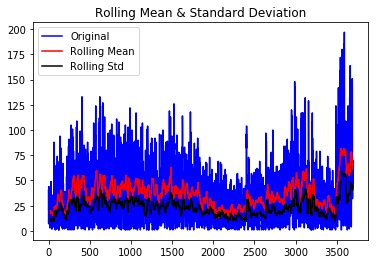

Results of Dickey-Fuller Test:
ADF Statistic: -5.297578
p-value: 0.000006
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
There is a  0.0006 % chance that my process is non stationary
Alternatively, There is a  99.9994 % chance that my process is stationary


In [21]:
test_stationarity(train_new['calls'],24)

In [22]:
train_new['target']=train_new['calls'].shift(-1)
#train_new['three hours rolling']=train_new['calldate'].rolling(window=3).mean()
#train_new['six hours rolling']=train_new['calldate'].rolling(window=6).mean()
#train_new['twelve hours rolling']=train_new['calldate'].rolling(window=12).mean()
#train_new['twenty-fours hours rolling']=train_new['calldate'].rolling(window=24).mean()
#train_new['three days rolling']=train_new['calldate'].rolling(window=72).mean()

train_new.dropna(inplace=True)

In [23]:
train_new.head()

,Date,calls,Month,Day,hour,target
0,2016010107,8,01,01,07,41.0
1,2016010108,41,01,01,08,20.0
2,2016010109,20,01,01,09,34.0
3,2016010110,34,01,01,10,44.0
4,2016010111,44,01,01,11,27.0


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
#def parser(x):
#	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 6
n_test = 1184
n_epochs = 10
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(train_new['calls'].astype('float64'), n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

# inverse transform forecasts and test
forecasts = inverse_transform(train_new['calls'].astype('float64'), forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(train_new['calls'], actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(train_new['calls'], forecasts, n_test+2)

In [24]:
X=train_new['calls'].astype('float64').values.reshape(-1, 1)
y=train_new['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,shuffle=False)

print(X_train.shape)
print(X_test.shape)

(3326, 1)
(370, 1)


In [43]:
#from sklearn.preprocessing import MinMaxScaler
#sc=MinMaxScaler()
#X_train=sc.fit_transform(X_train)
#X_test=sc.transform(X_test)

data=X_train
# AR example
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

# fit model
#model = AR(data)
model = ARMA(X, order=(2, 1))
model_fit = model.fit()
# make prediction
#yhat = model_fit.predict(start=X_train.shape[0], end=X_train.shape[0]+X_test.shape[0]-1)
yhat=model_fit.forecast(X_test.shape[0])

print(yhat[0].shape)
print(y_test.shape)

from sklearn.metrics import mean_squared_error
print("Model's RMSE is:",np.sqrt(mean_squared_error(y_test,yhat[0])))

#yhat = model_fit.predict(start=30, end=4780)

(370,)
(370,)
Model's RMSE is: 42.72151415254042


In [44]:
yhat

(array([49.01134331, 45.72217819, 43.57130379, 42.01861415, 40.84563203,
        39.9426697 , 39.24237456, 38.69768546, 38.27355374, 37.94315439,
        37.68573028, 37.48515069, 37.32885937, 37.20707627, 37.11218184,
        37.03823918, 36.98062233, 36.93572668, 36.90074354, 36.87348431,
        36.85224364, 36.83569269, 36.82279602, 36.8127468 , 36.80491635,
        36.79881478, 36.79406037, 36.79035569, 36.78746896, 36.78521959,
        36.78346686, 36.78210112, 36.78103691, 36.78020768, 36.77956153,
        36.77905804, 36.77866572, 36.77836001, 36.77812181, 36.7779362 ,
        36.77779156, 36.77767887, 36.77759105, 36.77752262, 36.77746931,
        36.77742776, 36.77739539, 36.77737016, 36.7773505 , 36.77733519,
        36.77732325, 36.77731395, 36.77730671, 36.77730106, 36.77729666,
        36.77729323, 36.77729056, 36.77728848, 36.77728686, 36.77728559,
        36.77728461, 36.77728384, 36.77728324, 36.77728278, 36.77728241,
        36.77728213, 36.77728191, 36.77728174, 36.7

In [31]:
import statsmodels.api as sm

In [ ]:
yhat = model_fit.predict(start=30, end=4780)
df=pd.DataFrame(yhat)
df.to_csv('AR.csv',index=False)

In [37]:
# SES example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# fit model
model = SimpleExpSmoothing(data)
model_fit = model.fit()
# make prediction
#yhat = model_fit.predict(start=X_train.shape[0], end=X_train.shape[0]+X_test.shape[0]-1)
yhat=model_fit.forecast(X_test.shape[0])


print(yhat.shape)
print(y_test.shape)

from sklearn.metrics import mean_squared_error
print("Model's RMSE is:",np.sqrt(mean_squared_error(y_test,yhat)))

#yhat = model_fit.predict(start=30, end=4780)
#df=pd.DataFrame(yhat)
#df.to_csv('SES.csv',index=False)

(370,)
(370,)
Model's RMSE is: 40.84170411731699


In [40]:
yhat

array([48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 48.017108, 48.017108,
       48.017108, 48.017108, 48.017108, 48.017108, 

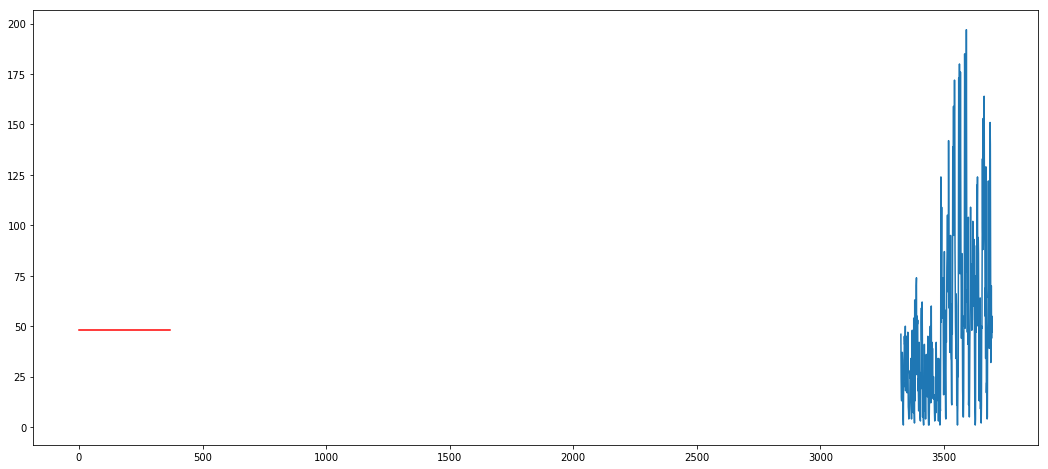

In [39]:
plt.plot(y_test)
plt.plot(yhat,'r')

In [ ]:
# SES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(start=X_train.shape[0], end=X_train.shape[0]+X_test.shape[0]-1)

#print(yhat.shape)
#print(y_test.shape)

#from sklearn.metrics import mean_squared_error
#print("Model's RMSE is:",np.sqrt(mean_squared_error(y_test,yhat)))

yhat = model_fit.predict(start=30, end=4780)
df=pd.DataFrame(yhat)
df.to_csv('ES.csv',index=False)

In [30]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = X_train
# fit model
model = ARMA(data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(start=X_train.shape[0], end=X_train.shape[0]+X_test.shape[0]-1)

#print(yhat.shape)
#print(y_test.shape)

from sklearn.metrics import mean_squared_error
print("Model's RMSE is:",np.sqrt(mean_squared_error(y_test,yhat)))

#yhat = model_fit.predict(start=30, end=4780)
#df=pd.DataFrame(yhat)
#df.to_csv('ARMA.csv',index=False)

Model's RMSE is: 43.10141832312021


In [ ]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = X_train
# fit model
model = ARMA(data, order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(start=X_train.shape[0], end=X_train.shape[0]+X_test.shape[0]-1)

#print(yhat.shape)
#print(y_test.shape)

#from sklearn.metrics import mean_squared_error
#print("Model's RMSE is:",np.sqrt(mean_squared_error(y_test,yhat)))

yhat = model_fit.predict(start=30, end=4780)
df=pd.DataFrame(yhat)
df.to_csv('ARMA2.csv',index=False)

In [ ]:
model.forecast?

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
X=train_new.drop(['target','Date','Month','calls'],axis=1)
y=train_new['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()

In [ ]:
X=train_new.drop(['target','Date','Month','calls'],axis=1)
y=train_new['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
cb=CatBoostRegressor(iterations=2000,learning_rate=0.1,depth=5,use_best_model=True,random_seed=12,eval_metric='RMSE')

In [ ]:
cb.fit(X_train,y_train,use_best_model=True,eval_set=(X_test,y_test),verbose=50, early_stopping_rounds=50)

In [ ]:
fea_imp = pd.DataFrame({'imp': cb.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [ ]:
df=Ce(np.round(cb.predict(sc.transform(test.drop(['time_index','Month'],axis=1))),0))
df.to_csv('mycsvfile2.csv',index=False)
